# Using Deep Learning for Sentence Score Prediction - Convolutional Neural Networks
## Overview

Sentence-to-sentence Convolutional Neural Network for text regression

#### Approach
- Split this data set into two sets - one for training our DL model, and one for evaluation  
- Use Keras to create a Convolutional Neural Network (CNN) with multiple layers. We will train this model on both CPU and GPU environments and compare runtimes  
- Evaluate and test the model on the test set and look at a few individual yelp examples  




In [1]:
import numpy as np
import pandas as pd
import os, re, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from multiprocessing import cpu_count
print(cpu_count())

16


In [2]:
import tensorflow as tf

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model

from tensorflow.keras.datasets import imdb

from tensorflow.keras.utils import model_to_dot

2023-05-19 22:05:12.144008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 22:05:15.580799: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-19 22:05:15.580930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [3]:
tf.config.list_physical_devices()

2023-05-19 22:05:17.934671: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-19 22:05:17.934728: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-19 22:05:17.934764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml-essay-grading): /proc/driver/nvidia/version does not exist


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
df_proc=pd.read_csv('../00_gcp_data/preprocessed-essay.csv')
df_proc.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cleaned_tokenize_text,corrected_text,...,sent_count,sent_len,mistakes,num_mistakes,word_count,noun_count,verb_count,adjective_count,adverb_count,Score_Category
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,think students would benefit learning home won...,think students would benefit learning home won...,...,18,14.500000,NaN,0,261,61,25,25,5,medium
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,problem change let best matter happening chang...,problem change let best matter happening chang...,...,14,38.071429,NaN,0,533,100,56,37,9,medium
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,dear principal change school policy grade aver...,dear principal change school policy grade aver...,...,19,16.842105,NaN,0,320,58,20,33,5,medium
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,best time life become agree greatest accomplis...,best time life become agree greatest accomplis...,...,36,20.222222,NaN,0,728,106,73,62,22,high
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act kindness impact people change people...,small act kindness impact people change people...,...,3,78.000000,kindess homeles triying greate kindess wount t...,11,234,58,21,18,5,medium


In [143]:
pd.options.display.max_colwidth=None
df_proc[['corrected_text','lemmatized_text']].sample(2)

,corrected_text,lemmatized_text
2759,anyone life shared wisdom experience ask someone important would love share maybe dad mon grandparents tones experience past person shared wisdom experience would father showed respectful adults show work business papers one thing father shared respect adults example father always best child would bad choices like going friends time listen parents got older realized one though serious rejected thought trouble child soon born able talk walk father would make say please thank well listening adults bow entering door greeting father want like younger made sure respectful grandparents shows father gave experience get respected family another thing father shared work business instance past months father showed paper work second job dad count money getting much give back workers times dad would come room teach split money making pay bills days showed showed much money everything made realized need work hard want simple job much gave job pay bills need work hard school shows father really cares future want well life showed wisdom hard like well school closing father taught business process one want business conclusion person showed wisdom experience would father teaching respect adult paper work job showed telling past show mange business older people important shared wisdom experience experience wisdom would share people people,anyone life share wisdom experience ask someone important would love share maybe dad mon grandparent tone experience past person share wisdom experience would father show respectful adult show work business paper one thing father share respect adult example father always best child would bad choice like go friend time listen parent get old realize one though serious reject thought trouble child soon born able talk walk father would make say please thank well listen adult bow enter door greet father want like young make sure respectful grandparent show father give experience get respect family another thing father share work business instance past month father show paper work second job dad count money get much give back worker time dad would come room teach split money make pay bill day show show much money everything make realize need work hard want simple job much give job pay bill need work hard school show father really care future want well life show wisdom hard like well school closing father taught business process one want business conclusion person show wisdom experience would father teach respect adult paper work job show tell past show mange business old people important share wisdom experience experience wisdom would share people people
192,dear principal honoured write letter pray take time busy schedule read letter hope good also want say happy student school first take stand decision changing school food healthier one say good one thoughtful idea also shows love school appreciate great idea good idea half student allergic reaction food chief cook rather hungry empty stomach incident still goes student might even pass one day secondly get healthier food active brains able function well soon class start however good breakfast even good food begin day sometimes help brain work well also help make brain good position working day work brain also consist contain particular minerals like carbohydrate protein fat supplementary substance also help human growth also help give energy human body lastly changing school food also make student never tried school lunch want try moreover student order food deliver school like school food allergic certain food incident keeps happening school food waste make school loose money therefore end speech saying good nice decision change school food healthier one once hope take time busy schedule read letter,dear principal honour write letter pray take time busy schedule read letter hope good also want say happy student school first take stand decision change school food healthier one say good one thoughtful idea also show love school 

### At first only predicting cohesion scores

In [7]:
## Setting text and target variables

textVar=df_proc['lemmatized_text']
targetVar=df_proc['cohesion']

In [8]:
## Splitting into train and test

X = textVar
Y = targetVar

# encoder = preprocessing.LabelEncoder()
# encoder.fit(targetVar)
# Y = encoder.transform(targetVar)

X_train, X_test, y_train, y_test = \
train_test_split(X, Y, test_size = 0.20, random_state = 1010)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(3128,) (3128,)
(783,) (783,)


In [144]:
X_train[:2]

812      prompt ask take position issue support response reason specific example prompt counterargument once take position issue people make decision seek guidance expert authority life important matter people make decision one point another there always go time go make decision something like example every four year there always selection new government mean new government mean like new president make selection decision make self situation look commit beneficial good star make decision self specially young adult high school right ask bad choice change star make good decision list try make right decision school
185    think curfew good idea adopt least student die street loneliness teen would brake law big trouble teen street fight crime shoot weapon etc curfew take care least temporary depends government need take care homeless teen drop high school early bad student decide learn try hard subject success future without education real world one need educate complete high school take ca

### Parameters

In [116]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100
num_filters = 10
filter_size = 3

# Here we specify the number of units of our hidden layer
hidden_dims = 5

# Training parameters. Here we specify the training of the net will use 64 examples for each backprop iteration
batch_size = 64

# We will go thru the entire data set 80 times
num_epochs = 40

# Prepossessing parameters
# We will input the first 1000 words of every essay (and pad out with nulls if a essay review is <1000 words
# We will also build our model using the most frequent 6000 words in our yelp 'dictionary'

sequence_length = 1000
max_features = 6000

#Specify the number of variables to predict (1 for binary classification or count unique values for multilabel classification)
num_classes = 1
#num_classes = target.nunique()

### Tokenize the data and pad sequences

In [117]:
tokenizer = Tokenizer(num_words=max_features, char_level=False)

#Fit tokenizer to entire data (not just Train)
tokenizer.fit_on_texts(df_proc["lemmatized_text"].values)

input_vocab_size = len(tokenizer.word_index) + 1
vocabulary = tokenizer.word_index
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

x_train = tokenizer.texts_to_sequences(X_train.values)
x_train = sequence.pad_sequences(x_train, maxlen=sequence_length, padding="post",
                                 truncating="post")

x_test = tokenizer.texts_to_sequences(X_test.values)
x_test = sequence.pad_sequences(x_test, maxlen=sequence_length, padding="post",
                                 truncating="post")

In [118]:
x_train

array([[ 666,   84,   20, ...,    0,    0,    0],
       [  15,  284,   10, ...,    0,    0,    0],
       [  18,  289,    8, ...,    0,    0,    0],
       ...,
       [  42,   96, 1260, ...,    0,    0,    0],
       [ 509,  356,   53, ...,    0,    0,    0],
       [ 635,  540,  553, ...,    0,    0,    0]], dtype=int32)

In [119]:
X_train[:3]

812                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [120]:
y_train

812     2.5
185     2.5
725     3.5
2532    4.0
3573    3.0
       ... 
2549    3.0
3090    4.0
202     3.0
1736    2.5
3620    3.0
Name: cohesion, Length: 3128, dtype: float64

In [121]:
if sequence_length != x_test.shape[1]:
    print("Adjusting sequence length for actual size")
    sequence_length = x_test.shape[1]


print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

x_train shape: (3128, 1000)
x_test shape: (783, 1000)
Vocabulary Size: 10283


In [122]:
print("y train shape is %s" % (y_train.shape,))
print("y test shape is %s" % (y_test.shape,))

y train shape is (3128,)
y test shape is (783,)


### Load a pretrained vector space model

In [124]:
embeddings_index = {}

glove_dir = '../00_gcp_data/'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [125]:
len(embeddings_index['student'])

100

In [126]:
# Create our embedding matrix - this will allow us to go from a word in our yelp to its vector space representation

embedding_matrix = np.zeros((len(vocabulary) + 1, embedding_dim))
for word, i in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if (word=='university'):
        print("word is %s at index %d " % (word, i))
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

word is university at index 551 


In [127]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.79618001,  0.56779999, -0.96452999, ..., -0.28637001,
         0.54822999, -0.33597001],
       [ 0.29019001,  0.80497003,  0.31187001, ..., -0.33603001,
         0.45998001, -0.11278   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.44525999,  0.17578   , -0.54009002, ..., -0.33307999,
        -0.90337998,  0.0175    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [128]:
print("Our vocab has word count %d" % (len(vocabulary)+1))
print("Matrix shape is ", embedding_matrix.shape)
print("Example row is ", embedding_matrix[100])

Our vocab has word count 10283
Matrix shape is  (10283, 100)
Example row is  [ 0.058792    0.46122     0.95361    -0.35800999 -0.37367001  0.74261999
 -0.50187999  0.24525     0.2958     -0.76233     0.36491999  0.043526
  0.34975001 -0.29161    -0.10035    -0.28575    -0.34646001  0.71338999
 -0.43531001  0.58613998 -0.23838     0.082975   -0.32286999 -1.03610003
  0.19852     0.19776    -0.47338    -0.51177001  0.45921999 -0.41784999
 -0.029453    0.94788003  0.42048001  0.10861     0.30035001  0.045433
 -0.084829    0.083592    0.17925    -0.52122003 -0.45185    -0.084647
  0.39475    -0.39993    -0.44732001 -0.031859   -0.23484001  0.14524999
 -0.11945    -1.11389995  0.35323    -0.12512    -0.16362999  0.79565001
 -0.017578   -2.02090001  0.12223     0.085044    1.2938      0.24239001
  0.24686     0.82770997 -0.23009001 -0.35879001  0.42050001  0.35205999
  0.60115999  0.21159001 -0.13845     0.0030674   0.14346001 -0.3942
  0.035264   -0.23196     0.62360001  0.50643998  0.14004

## Create a network architecture

In [129]:
# Use the pre trained GloVe model for our embedding layer
embedding_glove = Embedding(len(vocabulary) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=sequence_length,
                            trainable=False)

In [130]:
def cnn_create(embedding):
    """
    Create basic cnn structure
    embedding: keras Embedding
    return: compiled keras model
    """
    model = Sequential()

    model.add(embedding)

    model.add(Convolution1D(filters=10,
                             kernel_size=3,
                             padding="valid",
                             activation="relu",
                             strides=1))
    model.add(Convolution1D(filters=10,
                             kernel_size=3,
                             padding="valid",
                             activation="relu",
                             strides=1))
    
    model.add(GlobalMaxPooling1D())

    # We add a dense layer (fully connected) to the previous layer with a 20% dropout (ignore 20% of units during weight updates)
    hidden_dims = 5
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.1))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a linear (for regression):
    model.add(Dense(num_classes))
    model.add(Activation('linear')) #use softmax for multilabel
    return(model)


In [131]:
glove_model = cnn_create(embedding_glove)
glove_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [132]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [133]:
glove_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 100)         1028300   
                                                                 
 conv1d_9 (Conv1D)           (None, 998, 10)           3010      
                                                                 
 conv1d_10 (Conv1D)          (None, 996, 10)           310       
                                                                 
 global_max_pooling1d_4 (Glo  (None, 10)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 5)                 55        
                                                                 
 dropout_4 (Dropout)         (None, 5)                 0         
                                                      

In [134]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(glove_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [135]:
# import pydotplus

# from tensorflow.keras.utils import model_to_dot
# dot = model_to_dot(glove_model, show_shapes=True)
# graph = pydotplus.graph_from_dot_data(dot.to_string())
# graph.write_png('model.png')

In [136]:
# SVG(model_to_dot(glove_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

# %pip install pydot_ng
# import pydot_ng
# from pydot_ng import model_to_dot
# SVG(model_to_dot(glove_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))


In [137]:
# %pip install pydot

# from tensorflow.keras.utils import plot_model
# plot_model(glove_model, show_shapes=True, to_file='model.png')

In [138]:
filepath="..00_gcp_data/dl_models/cnn_glove_weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='max')
#only save model if it improves the accuracy

callbacks_list = [checkpoint]

t1 = time.time()
glove_history = glove_model.fit(x_train, y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_data=(x_test, y_test),
                    callbacks = callbacks_list,
                    verbose=2)
t2 = time.time()
print("CNN Glove model train time = %d seconds" %(t2-t1))

Epoch 1/200
49/49 - 2s - loss: 1.0438 - mean_squared_error: 1.0438 - val_loss: 0.5521 - val_mean_squared_error: 0.5521 - 2s/epoch - 47ms/step
Epoch 2/200
49/49 - 1s - loss: 0.8826 - mean_squared_error: 0.8826 - val_loss: 0.4787 - val_mean_squared_error: 0.4787 - 1s/epoch - 28ms/step
Epoch 3/200
49/49 - 1s - loss: 0.7263 - mean_squared_error: 0.7263 - val_loss: 0.4587 - val_mean_squared_error: 0.4587 - 1s/epoch - 27ms/step
Epoch 4/200
49/49 - 1s - loss: 0.6973 - mean_squared_error: 0.6973 - val_loss: 0.4393 - val_mean_squared_error: 0.4393 - 1s/epoch - 27ms/step
Epoch 5/200
49/49 - 1s - loss: 0.6846 - mean_squared_error: 0.6846 - val_loss: 0.4154 - val_mean_squared_error: 0.4154 - 1s/epoch - 29ms/step
Epoch 6/200
49/49 - 1s - loss: 0.7028 - mean_squared_error: 0.7028 - val_loss: 0.4122 - val_mean_squared_error: 0.4122 - 1s/epoch - 28ms/step
Epoch 7/200
49/49 - 1s - loss: 0.6807 - mean_squared_error: 0.6807 - val_loss: 0.4263 - val_mean_squared_error: 0.4263 - 1s/epoch - 28ms/step
Epoch 

In [139]:
glove_history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [140]:
def plot_train(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    #loss_values = history_dict['loss']
    #val_loss_values = history_dict['val_loss']
    #acc = history_dict['acc']
    #val_acc = history_dict['val_accuracy']
    
    #plt.plot(epochs, loss_values, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    
    epochs = range(1, len(h['mean_squared_error']) + 1)
    plt.plot(epochs, h['mean_squared_error'], 'go', label='Training MSE')
    plt.plot(epochs, h['val_mean_squared_error'], 'g', label='Validation MSE')
    plt.title('Training and Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

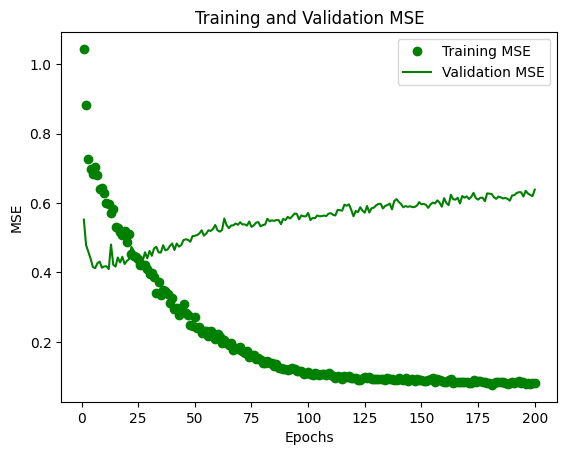

In [141]:
plot_train(glove_history)

In [142]:
glove_history.model.get_config()

{'name': 'sequential_4',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1000),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'embedding_3_input'}},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding_3',
    'trainable': False,
    'dtype': 'float32',
    'batch_input_shape': (None, 1000),
    'input_dim': 10283,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 1000}},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d_9',
    'trainable': True,
    'dtype': 'float32',
    'filters': 10,
    'kernel_size': (3,),
    'strides': (1,),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1,),
    'groups': 1,
    'activation': 'rel

----
## Now trying for 6 different outputs

In [145]:
## Setting text and target variables

textVar=df_proc['lemmatized_text']
targetVar=df_proc[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]

In [146]:
## Splitting into train and test

X = textVar
Y = targetVar

# encoder = preprocessing.LabelEncoder()
# encoder.fit(targetVar)
# Y = encoder.transform(targetVar)

X_train, X_test, y_train, y_test = \
train_test_split(X, Y, test_size = 0.20, random_state = 1010)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(3128,) (3128, 6)
(783,) (783, 6)


In [147]:
tokenizer = Tokenizer(num_words=max_features, char_level=False)

#Fit tokenizer to entire data (not just Train)
tokenizer.fit_on_texts(df_proc["lemmatized_text"].values)

input_vocab_size = len(tokenizer.word_index) + 1
vocabulary = tokenizer.word_index
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

x_train = tokenizer.texts_to_sequences(X_train.values)
x_train = sequence.pad_sequences(x_train, maxlen=sequence_length, padding="post",
                                 truncating="post")

x_test = tokenizer.texts_to_sequences(X_test.values)
x_test = sequence.pad_sequences(x_test, maxlen=sequence_length, padding="post",
                                 truncating="post")

In [149]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

x_train shape: (3128, 1000)
x_test shape: (783, 1000)
Vocabulary Size: 10283


In [150]:
# Create our embedding matrix - this will allow us to go from a word in our yelp to its vector space representation

embedding_matrix = np.zeros((len(vocabulary) + 1, embedding_dim))
for word, i in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if (word=='university'):
        print("word is %s at index %d " % (word, i))
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

word is university at index 551 


### Creating a new architecture

In [151]:
# Use the pre trained GloVe model for our embedding layer
embedding_glove = Embedding(len(vocabulary) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=sequence_length,
                            trainable=False)

In [158]:
def cnn_create_all(embedding):
    """
    Create basic cnn structure
    embedding: keras Embedding
    return: compiled keras model
    """
    model = Sequential()

    model.add(embedding) # Adding our glove embedding

    model.add(Convolution1D(filters=20,
                             kernel_size=5,
                             padding="valid",
                             activation="relu",
                             strides=1))
    
    model.add(Convolution1D(filters=40,
                             kernel_size=3,
                             padding="valid",
                             activation="relu",
                             strides=1))
        
    model.add(GlobalMaxPooling1D())

    # We add a dense layer (fully connected) to the previous layer with a 10% dropout (ignore 10% of units during weight updates)
    hidden_dims = 20
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.1))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a linear (for regression):
    model.add(Dense(6))
    model.add(Activation('linear')) #use softmax for multilabel
    return(model)


In [159]:
glove_model_all = cnn_create_all(embedding_glove)
glove_model_all.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 100)         1028300   
                                                                 
 conv1d_13 (Conv1D)          (None, 996, 20)           10020     
                                                                 
 conv1d_14 (Conv1D)          (None, 994, 40)           2440      
                                                                 
 global_max_pooling1d_6 (Glo  (None, 40)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 20)                820       
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                      

In [162]:
glove_model_all.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [163]:
filepath="..00_gcp_data/dl_models/cnn_glove_weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')
#only save model if it improves the accuracy

callbacks_list = [checkpoint]

t1 = time.time()
glove_history_all = glove_model_all.fit(x_train, y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_data=(x_test, y_test),
                    callbacks = callbacks_list,
                    verbose=2)
t2 = time.time()
print("CNN Glove_all model train time = %d seconds" %(t2-t1))

Epoch 1/200

Epoch 1: val_mean_squared_error improved from inf to 8.46718, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 4s - loss: 9.7151 - mean_squared_error: 9.7151 - val_loss: 8.4672 - val_mean_squared_error: 8.4672 - 4s/epoch - 76ms/step
Epoch 2/200

Epoch 2: val_mean_squared_error improved from 8.46718 to 5.84094, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 3s - loss: 7.3394 - mean_squared_error: 7.3394 - val_loss: 5.8409 - val_mean_squared_error: 5.8409 - 3s/epoch - 61ms/step
Epoch 3/200

Epoch 3: val_mean_squared_error improved from 5.84094 to 3.25389, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 3s - loss: 4.8744 - mean_squared_error: 4.8744 - val_loss: 3.2539 - val_mean_squared_error: 3.2539 - 3s/epoch - 57ms/step
Epoch 4/200

Epoch 4: val_mean_squared_error improved from 3.25389 to 1.31700, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 3s - loss: 2.7370 - mean_squared_error: 2.7370 - val_loss: 1.3170 - val_mean_squared_error: 1.3170 - 3s/epoch - 61ms/step
Epoch 5/200

Epoch 5: val_mean_squared_error improved from 1.31700 to 0.61635, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 3s - loss: 1.5766 - mean_squared_error: 1.5766 - val_loss: 0.6164 - val_mean_squared_error: 0.6164 - 3s/epoch - 55ms/step
Epoch 6/200

Epoch 6: val_mean_squared_error improved from 0.61635 to 0.48839, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 3s - loss: 1.2026 - mean_squared_error: 1.2026 - val_loss: 0.4884 - val_mean_squared_error: 0.4884 - 3s/epoch - 53ms/step
Epoch 7/200

Epoch 7: val_mean_squared_error did not improve from 0.48839
49/49 - 2s - loss: 1.0896 - mean_squared_error: 1.0896 - val_loss: 0.4897 - val_mean_squared_error: 0.4897 - 2s/epoch - 40ms/step
Epoch 8/200

Epoch 8: val_mean_squared_error improved from 0.48839 to 0.46547, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 3s - loss: 1.0844 - mean_squared_error: 1.0844 - val_loss: 0.4655 - val_mean_squared_error: 0.4655 - 3s/epoch - 58ms/step
Epoch 9/200

Epoch 9: val_mean_squared_error improved from 0.46547 to 0.39294, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 3s - loss: 0.9505 - mean_squared_error: 0.9505 - val_loss: 0.3929 - val_mean_squared_error: 0.3929 - 3s/epoch - 59ms/step
Epoch 10/200

Epoch 10: val_mean_squared_error did not improve from 0.39294
49/49 - 2s - loss: 0.9918 - mean_squared_error: 0.9918 - val_loss: 0.4274 - val_mean_squared_error: 0.4274 - 2s/epoch - 35ms/step
Epoch 11/200

Epoch 11: val_mean_squared_error did not improve from 0.39294
49/49 - 2s - loss: 0.9194 - mean_squared_error: 0.9194 - val_loss: 0.3957 - val_mean_squared_error: 0.3957 - 2s/epoch - 35ms/step
Epoch 12/200

Epoch 12: val_mean_squared_error did not improve from 0.39294
49/49 - 2s - loss: 0.8971 - mean_squared_error: 0.8971 - val_loss: 0.4205 - val_mean_squared_error: 0.4205 - 2s/epoch - 35ms/step
Epoch 13/200

Epoch 13: val_mean_squared_error did not improve from 0.39294
49/49 - 2s - loss: 0.8653 - mean_squared_error: 0.8653 - val_loss: 0.4558 - val_mean_squared_error: 0.4558 - 2s/epoch - 35ms/step
Epoch 14/200

Epoch 14: val_mean_squared_error

INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 3s - loss: 0.8105 - mean_squared_error: 0.8105 - val_loss: 0.3886 - val_mean_squared_error: 0.3886 - 3s/epoch - 52ms/step
Epoch 16/200

Epoch 16: val_mean_squared_error did not improve from 0.38861
49/49 - 2s - loss: 0.8452 - mean_squared_error: 0.8452 - val_loss: 0.3886 - val_mean_squared_error: 0.3886 - 2s/epoch - 34ms/step
Epoch 17/200

Epoch 17: val_mean_squared_error did not improve from 0.38861
49/49 - 2s - loss: 0.8053 - mean_squared_error: 0.8053 - val_loss: 0.3899 - val_mean_squared_error: 0.3899 - 2s/epoch - 34ms/step
Epoch 18/200

Epoch 18: val_mean_squared_error improved from 0.38861 to 0.37816, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 3s - loss: 0.8054 - mean_squared_error: 0.8054 - val_loss: 0.3782 - val_mean_squared_error: 0.3782 - 3s/epoch - 52ms/step
Epoch 19/200

Epoch 19: val_mean_squared_error did not improve from 0.37816
49/49 - 2s - loss: 0.7686 - mean_squared_error: 0.7686 - val_loss: 0.4183 - val_mean_squared_error: 0.4183 - 2s/epoch - 35ms/step
Epoch 20/200

Epoch 20: val_mean_squared_error did not improve from 0.37816
49/49 - 2s - loss: 0.7610 - mean_squared_error: 0.7610 - val_loss: 0.4103 - val_mean_squared_error: 0.4103 - 2s/epoch - 34ms/step
Epoch 21/200

Epoch 21: val_mean_squared_error did not improve from 0.37816
49/49 - 2s - loss: 0.7179 - mean_squared_error: 0.7179 - val_loss: 0.3976 - val_mean_squared_error: 0.3976 - 2s/epoch - 34ms/step
Epoch 22/200

Epoch 22: val_mean_squared_error did not improve from 0.37816
49/49 - 2s - loss: 0.6995 - mean_squared_error: 0.6995 - val_loss: 0.3835 - val_mean_squared_error: 0.3835 - 2s/epoch - 35ms/step
Epoch 23/200

Epoch 23: val_mean_squared_error

KeyboardInterrupt: 

In [164]:
plot_train(glove_history_all)

NameError: name 'glove_history_all' is not defined

------

In [172]:
def cnn_create_all_2(embedding):
    """
    Create basic cnn structure
    embedding: keras Embedding
    return: compiled keras model
    """
    model = Sequential()

    model.add(embedding) # Adding our glove embedding

    model.add(Convolution1D(filters=128,
                             kernel_size=5,
                             padding="valid",
                             activation="relu",
                             strides=1))
    
    model.add(MaxPooling1D(5))
    
    model.add(Convolution1D(filters=128,
                             kernel_size=5,
                             padding="valid",
                             activation="relu",
                             strides=1))
    
    model.add(MaxPooling1D(5))

    model.add(Convolution1D(filters=128,
                             kernel_size=5,
                             padding="valid",
                             activation="relu",
                             strides=1))
    
        
    model.add(GlobalMaxPooling1D())

    # We add a dense layer (fully connected) to the previous layer with a 10% dropout (ignore 10% of units during weight updates)
    hidden_dims = 128
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.1))
    model.add(Activation('relu'))

    hidden_dims = 128
    model.add(Dense(20))
    model.add(Dropout(0.1))
    model.add(Activation('relu'))
    
    # We project onto a single unit output layer, and squash it with a linear (for regression):
    model.add(Dense(6))
    model.add(Activation('linear')) #use softmax for multilabel
    return(model)


In [173]:
glove_model_all_2 = cnn_create_all_2(embedding_glove)
glove_model_all_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 100)         1028300   
                                                                 
 conv1d_21 (Conv1D)          (None, 996, 128)          64128     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 conv1d_22 (Conv1D)          (None, 195, 128)          82048     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 39, 128)          0         
 1D)                                                             
                                                                 
 conv1d_23 (Conv1D)          (None, 35, 128)          

In [175]:
glove_model_all_2.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [176]:
num_epochs=40

filepath="..00_gcp_data/dl_models/cnn_glove_weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')
#only save model if it improves the accuracy

callbacks_list = [checkpoint]

t1 = time.time()
glove_history_all_2 = glove_model_all_2.fit(x_train, y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_data=(x_test, y_test),
                    callbacks = callbacks_list,
                    verbose=2)
t2 = time.time()
print("CNN Glove_all model train time = %d seconds" %(t2-t1))

Epoch 1/40

Epoch 1: val_mean_squared_error improved from inf to 0.50238, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 10s - loss: 2.2562 - mean_squared_error: 2.2562 - val_loss: 0.5024 - val_mean_squared_error: 0.5024 - 10s/epoch - 195ms/step
Epoch 2/40

Epoch 2: val_mean_squared_error improved from 0.50238 to 0.43439, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 8s - loss: 1.1865 - mean_squared_error: 1.1865 - val_loss: 0.4344 - val_mean_squared_error: 0.4344 - 8s/epoch - 162ms/step
Epoch 3/40

Epoch 3: val_mean_squared_error improved from 0.43439 to 0.41105, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 8s - loss: 0.8773 - mean_squared_error: 0.8773 - val_loss: 0.4110 - val_mean_squared_error: 0.4110 - 8s/epoch - 159ms/step
Epoch 4/40

Epoch 4: val_mean_squared_error improved from 0.41105 to 0.37709, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 8s - loss: 0.7730 - mean_squared_error: 0.7730 - val_loss: 0.3771 - val_mean_squared_error: 0.3771 - 8s/epoch - 161ms/step
Epoch 5/40

Epoch 5: val_mean_squared_error improved from 0.37709 to 0.35579, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


49/49 - 8s - loss: 0.6974 - mean_squared_error: 0.6974 - val_loss: 0.3558 - val_mean_squared_error: 0.3558 - 8s/epoch - 168ms/step
Epoch 6/40

Epoch 6: val_mean_squared_error did not improve from 0.35579
49/49 - 6s - loss: 0.6167 - mean_squared_error: 0.6167 - val_loss: 0.4261 - val_mean_squared_error: 0.4261 - 6s/epoch - 127ms/step
Epoch 7/40

Epoch 7: val_mean_squared_error did not improve from 0.35579
49/49 - 6s - loss: 0.5292 - mean_squared_error: 0.5292 - val_loss: 0.3958 - val_mean_squared_error: 0.3958 - 6s/epoch - 127ms/step
Epoch 8/40

Epoch 8: val_mean_squared_error did not improve from 0.35579
49/49 - 6s - loss: 0.4975 - mean_squared_error: 0.4975 - val_loss: 0.3580 - val_mean_squared_error: 0.3580 - 6s/epoch - 125ms/step
Epoch 9/40

Epoch 9: val_mean_squared_error did not improve from 0.35579
49/49 - 6s - loss: 0.4439 - mean_squared_error: 0.4439 - val_loss: 0.3888 - val_mean_squared_error: 0.3888 - 6s/epoch - 127ms/step
Epoch 10/40

Epoch 10: val_mean_squared_error did not

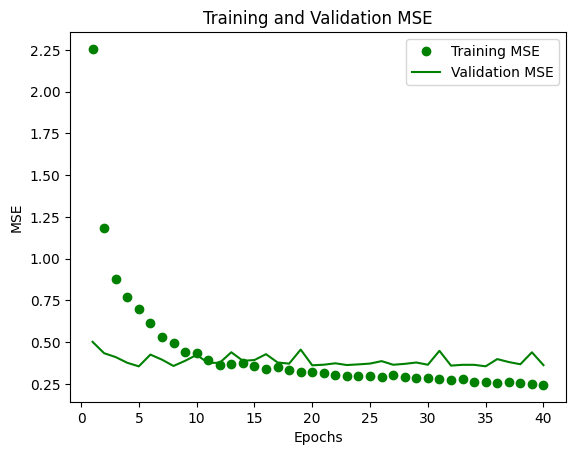

In [177]:
plot_train(glove_history_all_2)

In [182]:
glove_model_all_2.evaluate(x_test, y_test)

25/25 [==============================] - 0s 17ms/step - loss: 0.3629 - mean_squared_error: 0.3629


[0.36294636130332947, 0.36294636130332947]

In [185]:
predictions=glove_model_all_2.predict(x_test)
predictions

25/25 [==============================] - 1s 19ms/step


array([[3.0489163, 2.9810324, 3.2345102, 3.124455 , 3.0272224, 3.0460896],
       [2.8537164, 2.8989425, 3.0624042, 3.0014224, 2.9774299, 2.8804975],
       [3.2703729, 3.1660638, 3.4474597, 3.357874 , 3.2176816, 3.2534282],
       ...,
       [3.6491647, 3.4531093, 3.6333373, 3.4375525, 3.3969448, 3.5375135],
       [3.2502656, 3.17794  , 3.4307756, 3.276074 , 3.1889513, 3.2328906],
       [3.012453 , 2.8722043, 3.1931849, 3.0461802, 2.876765 , 2.989192 ]],
      dtype=float32)

In [188]:
def cnn_create_all_3(embedding):
    """
    Create basic cnn structure
    embedding: keras Embedding
    return: compiled keras model
    """
    model = Sequential()

    model.add(embedding) # Adding our glove embedding

    model.add(Convolution1D(filters=128,
                             kernel_size=5,
                             padding="valid",
                             activation="relu",
                             strides=1))
    
    model.add(MaxPooling1D(5))
    
    model.add(Convolution1D(filters=128,
                             kernel_size=5,
                             padding="valid",
                             activation="relu",
                             strides=1))
    
    model.add(MaxPooling1D(5))

    model.add(Convolution1D(filters=128,
                             kernel_size=5,
                             padding="valid",
                             activation="relu",
                             strides=1))
    
        
    model.add(GlobalMaxPooling1D())

    # We add a dense layer (fully connected) to the previous layer with a 10% dropout (ignore 10% of units during weight updates)
    hidden_dims = 128
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.1))
    model.add(Activation('relu'))

    hidden_dims = 128
    model.add(Dense(20))
    model.add(Dropout(0.1))
    model.add(Activation('relu'))
    
    # We project onto a single unit output layer, and squash it with a linear (for regression):
    model.add(Dense(6))
    model.add(Activation('linear')) #use softmax for multilabel
    return(model)


In [190]:
glove_model_all_3 = cnn_create_all_3(embedding_glove)
glove_model_all_3.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
glove_model_all_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 100)         1028300   
                                                                 
 conv1d_27 (Conv1D)          (None, 996, 128)          64128     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 conv1d_28 (Conv1D)          (None, 195, 128)          82048     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 39, 128)          0         
 1D)                                                             
                                                                 
 conv1d_29 (Conv1D)          (None, 35, 128)         

In [191]:
#-----
num_epochs=40

filepath="..00_gcp_data/dl_models/cnn_glove_weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')
#only save model if it improves the accuracy

callbacks_list = [checkpoint]

t1 = time.time()
glove_history_all_3 = glove_model_all_3.fit(x_train, y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    # validation_data=(x_test, y_test),
                    validation_split=0.20,
                    callbacks = callbacks_list,
                    verbose=2)
t2 = time.time()
print("CNN Glove_all model train time = %d seconds" %(t2-t1))

Epoch 1/40

Epoch 1: val_mean_squared_error improved from inf to 0.80104, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


40/40 - 7s - loss: 3.7776 - mean_squared_error: 3.7776 - val_loss: 0.8010 - val_mean_squared_error: 0.8010 - 7s/epoch - 183ms/step
Epoch 2/40

Epoch 2: val_mean_squared_error improved from 0.80104 to 0.54273, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


40/40 - 7s - loss: 1.4477 - mean_squared_error: 1.4477 - val_loss: 0.5427 - val_mean_squared_error: 0.5427 - 7s/epoch - 180ms/step
Epoch 3/40

Epoch 3: val_mean_squared_error improved from 0.54273 to 0.39855, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


40/40 - 6s - loss: 1.0575 - mean_squared_error: 1.0575 - val_loss: 0.3986 - val_mean_squared_error: 0.3986 - 6s/epoch - 147ms/step
Epoch 4/40

Epoch 4: val_mean_squared_error did not improve from 0.39855
40/40 - 5s - loss: 0.9077 - mean_squared_error: 0.9077 - val_loss: 0.4333 - val_mean_squared_error: 0.4333 - 5s/epoch - 125ms/step
Epoch 5/40

Epoch 5: val_mean_squared_error improved from 0.39855 to 0.39483, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


40/40 - 7s - loss: 0.7779 - mean_squared_error: 0.7779 - val_loss: 0.3948 - val_mean_squared_error: 0.3948 - 7s/epoch - 177ms/step
Epoch 6/40

Epoch 6: val_mean_squared_error did not improve from 0.39483
40/40 - 5s - loss: 0.7180 - mean_squared_error: 0.7180 - val_loss: 0.4457 - val_mean_squared_error: 0.4457 - 5s/epoch - 137ms/step
Epoch 7/40

Epoch 7: val_mean_squared_error improved from 0.39483 to 0.37410, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


40/40 - 7s - loss: 0.6895 - mean_squared_error: 0.6895 - val_loss: 0.3741 - val_mean_squared_error: 0.3741 - 7s/epoch - 166ms/step
Epoch 8/40

Epoch 8: val_mean_squared_error improved from 0.37410 to 0.37379, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


40/40 - 6s - loss: 0.6241 - mean_squared_error: 0.6241 - val_loss: 0.3738 - val_mean_squared_error: 0.3738 - 6s/epoch - 162ms/step
Epoch 9/40

Epoch 9: val_mean_squared_error improved from 0.37379 to 0.36855, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


40/40 - 7s - loss: 0.5529 - mean_squared_error: 0.5529 - val_loss: 0.3685 - val_mean_squared_error: 0.3685 - 7s/epoch - 172ms/step
Epoch 10/40

Epoch 10: val_mean_squared_error improved from 0.36855 to 0.35377, saving model to ..00_gcp_data/dl_models/cnn_glove_weights_best


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


INFO:tensorflow:Assets written to: ..00_gcp_data/dl_models/cnn_glove_weights_best/assets


40/40 - 6s - loss: 0.5235 - mean_squared_error: 0.5235 - val_loss: 0.3538 - val_mean_squared_error: 0.3538 - 6s/epoch - 158ms/step
Epoch 11/40

Epoch 11: val_mean_squared_error did not improve from 0.35377
40/40 - 5s - loss: 0.4849 - mean_squared_error: 0.4849 - val_loss: 0.4277 - val_mean_squared_error: 0.4277 - 5s/epoch - 125ms/step
Epoch 12/40

Epoch 12: val_mean_squared_error did not improve from 0.35377
40/40 - 5s - loss: 0.4730 - mean_squared_error: 0.4730 - val_loss: 0.5672 - val_mean_squared_error: 0.5672 - 5s/epoch - 123ms/step
Epoch 13/40

Epoch 13: val_mean_squared_error did not improve from 0.35377
40/40 - 5s - loss: 0.4821 - mean_squared_error: 0.4821 - val_loss: 0.4348 - val_mean_squared_error: 0.4348 - 5s/epoch - 124ms/step
Epoch 14/40

Epoch 14: val_mean_squared_error did not improve from 0.35377
40/40 - 5s - loss: 0.4484 - mean_squared_error: 0.4484 - val_loss: 0.3766 - val_mean_squared_error: 0.3766 - 5s/epoch - 123ms/step
Epoch 15/40

Epoch 15: val_mean_squared_error

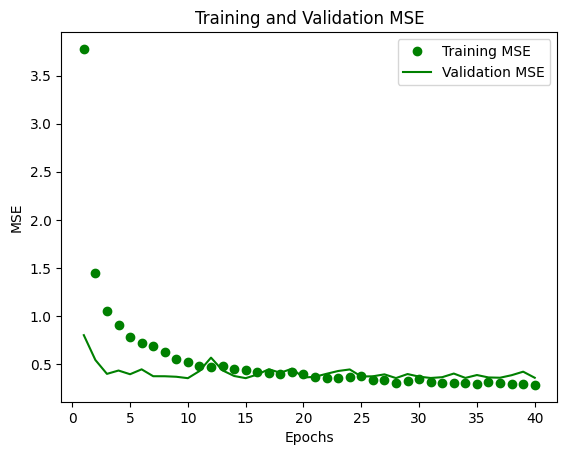

In [192]:
plot_train(glove_history_all_3)

In [193]:
glove_model_all_3.evaluate(x_test,y_test)

25/25 [==============================] - 0s 18ms/step - loss: 0.3645 - mean_squared_error: 0.3645


[0.3645419776439667, 0.3645419776439667]

In [213]:
0.3645419776439667**0.5

0.6037731176890593

In [195]:
predictions=glove_model_all_3.predict(x_test)

25/25 [==============================] - 0s 17ms/step


In [196]:
predictions

array([[2.9435241, 2.8691924, 3.046857 , 2.9629157, 2.8855069, 2.9222417],
       [3.0587292, 2.951613 , 3.1344953, 3.0197513, 2.9657662, 2.982942 ],
       [3.273987 , 3.1663659, 3.3610446, 3.2694001, 3.187663 , 3.232811 ],
       ...,
       [3.4769807, 3.360465 , 3.5595572, 3.4607508, 3.3897095, 3.427609 ],
       [3.3047535, 3.2233562, 3.401797 , 3.3345664, 3.2408583, 3.283698 ],
       [3.1333504, 3.0598054, 3.2359397, 3.167062 , 3.0724351, 3.1180844]],
      dtype=float32)

In [197]:
rounded_predictions = np.round(predictions * 2) / 2
print(rounded_predictions)


[[3.  3.  3.  3.  3.  3. ]
 [3.  3.  3.  3.  3.  3. ]
 [3.5 3.  3.5 3.5 3.  3. ]
 ...
 [3.5 3.5 3.5 3.5 3.5 3.5]
 [3.5 3.  3.5 3.5 3.  3.5]
 [3.  3.  3.  3.  3.  3. ]]


In [202]:
y_test_orig=np.array(y_test)
y_test_orig

array([[4. , 3.5, 3.5, 3.5, 3.5, 4. ],
       [2.5, 3. , 2.5, 2.5, 2.5, 3. ],
       [2.5, 2.5, 3. , 3. , 2.5, 3. ],
       ...,
       [3. , 3.5, 3. , 3. , 4. , 2. ],
       [4. , 4. , 3. , 3.5, 3.5, 3.5],
       [3. , 3.5, 3.5, 3.5, 4. , 4. ]])

In [211]:
np.mean(np.sqrt(np.mean(((y_test_orig)-(rounded_predictions))**2,axis=0)))

0.6215473244678112